# MIMIC-IV Sepsis Predictions
Throughout this notebook, we will gather, clean, and analyze data on sepsis patients who presented to the Beth Israel Deaconess Medical Center (BIDMC) in Boston between 2011-2019. This data is available to researchers globally through the MIMIC-IV database. The goal of the project is to create a dataset of baseline measurements of sepsis patients and then try and cluster them together to find homogeneous subgroups of patients with similar characteristics. These clusters of similar patients are perhaps more likely to respond uniformly to certain treatment strategies.

## Loading in all necessary modules and files
First, we load all the necessary modules for the complete notebook in the cell below. Then we load in all the necessary csv files that we will use throughout this project.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer
from tableone import TableOne
from sklearn.metrics import confusion_matrix

pd.set_option("mode.chained_assignment", None) 

In [2]:
patients = pd.read_csv("/Users/michielschinkel/Library/CloudStorage/OneDrive-Personal/Documenten/Datasets/MIMIC IV/core/patients.csv")
admissions = pd.read_csv("/Users/michielschinkel/Library/CloudStorage/OneDrive-Personal/Documenten/Datasets/MIMIC IV/core/admissions.csv")
diagnoses = pd.read_csv("/Users/michielschinkel/Library/CloudStorage/OneDrive-Personal/Documenten/Datasets/MIMIC IV/hosp/diagnoses_icd.csv")
icd_codes = pd.read_csv("/Users/michielschinkel/Library/CloudStorage/OneDrive-Personal/Documenten/Datasets/MIMIC IV/hosp/d_icd_diagnoses.csv")
baseline = pd.read_csv("/Users/michielschinkel/Library/CloudStorage/OneDrive-Personal/Documenten/Datasets/MIMIC IV/ed/edstays.csv")
microbiology = pd.read_csv("/Users/michielschinkel/Library/CloudStorage/OneDrive-Personal/Documenten/Datasets/MIMIC IV/hosp/microbiologyevents.csv", usecols=["subject_id", "charttime", "spec_type_desc", "org_itemid", "org_name"]) 
vitals = pd.read_csv("/Users/michielschinkel/Library/CloudStorage/OneDrive-Personal/Documenten/Datasets/MIMIC IV/ed/vitalsign.csv")
lab = pd.read_csv("/Users/michielschinkel/Library/CloudStorage/OneDrive-Personal/Documenten/Datasets/MIMIC IV/hosp/labevents.csv", usecols=["subject_id", "itemid", "charttime", "value"])
lab_items = pd.read_csv("/Users/michielschinkel/Library/CloudStorage/OneDrive-Personal/Documenten/Datasets/MIMIC IV/hosp/d_labitems.csv", usecols=["itemid", "label", "fluid"])

/var/folders/pf/j_1jwxsx3lzdvxnvj30kd2hw0000gn/T/ipykernel_62232/2034795167.py:8: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  lab = pd.read_csv("/Users/michielschinkel/Library/CloudStorage/OneDrive-Personal/Documenten/Datasets/MIMIC IV/hosp/labevents.csv", usecols=["subject_id", "itemid", "charttime", "value"])


## Creating a baseline file
We will start by creating a baseline dataframe which we will extend with other data. The baseline file is created from a file on individual stays in the emergency department (ED) of BIDMC and consists of a patient identified (subject_id), stay identifier (stay_id), and the times at which the patient was in the ED. In the cell below, we first set these times to the correct date-time format, so we can use them to find laboratory results and vital sign measurements within this timeframe to add to the dataset.

In [3]:
baseline["intime"] = pd.to_datetime(baseline["intime"])
baseline["outtime"] = pd.to_datetime(baseline["outtime"])

Below, we clean up the results of microbiology tests to find the bacterium that causes sepsis. Most important in that regard are blood cultures, in which we can see whether a patient has a bacterium in the bloodstream. Culture-positive and culture-negative sepsis are thought to be quite different, so this feature should be included in the clusteranalyses.

In [4]:
blood_cultures = microbiology[(microbiology["spec_type_desc"] == "BLOOD CULTURE") & (microbiology["org_name"] != "CANCELLED")]
blood_cultures["charttime"] = pd.to_datetime(blood_cultures["charttime"])
blood_cultures["blood_culture_result"] = np.where(blood_cultures["org_name"].isnull(), 0, 1)


In [5]:
all_cultures = pd.merge(baseline, blood_cultures, on="subject_id", how="left")
all_cultures = all_cultures[(all_cultures["charttime"] >= all_cultures["intime"]) & (all_cultures["charttime"] <= all_cultures["outtime"])]
all_cultures = all_cultures.groupby("stay_id").max("blood_culture_result")
all_cultures = all_cultures["blood_culture_result"]

baseline_cultures = pd.merge(baseline, all_cultures, on="stay_id", how="left")

## Adding vital signs
In the cell below, we will add vital sign measurements, such as heartrate and blood pressure, to the dataset. When one patient has multiple measurements during their ED stay, we select the first. This is the measurement that will be least biased/influenced by treatments that are given in the ED.

In [6]:
vitals = vitals.groupby("stay_id").first("charttime")
vitals = vitals.drop(columns="subject_id")
baseline_cultures_vitals = pd.merge(baseline_cultures, vitals, on="stay_id", how="left")

## Creating files with sepsis diagnosis labels
Below, we will find the visits with sepsis diagnosis labels through their ICD-10 codes (International Classification of Diseases). From the broad dataset we had of all ED visits, we now narrow it down only to the goal population of sepsis patients. We perform this step now as it was otherwise hard to incorporate all laboratory results already, since there were over 300 million results for the complete population.

In [7]:
sepsis_codes = icd_codes.query('long_title.str.contains("sepsis")')
sepsis_diagnoses = diagnoses.loc[diagnoses["icd_code"].isin(sepsis_codes["icd_code"])]
baseline_cultures_vitals["sepsis"] = np.where(baseline_cultures_vitals["hadm_id"].isin(sepsis_diagnoses["hadm_id"]), 1, 0)
base_population = baseline_cultures_vitals[baseline_cultures_vitals["sepsis"] == 1]

## Adding laboratory results
Now that we have the goal population, we will add the laboratory results. The laboratory test values and types of tests are stored in different files, so we first need to merge those to get the correct labels with the lab tests.

In [8]:
lab_labelled = lab[lab["subject_id"].isin(base_population["subject_id"])]
lab_labelled = pd.merge(lab_labelled, lab_items, on="itemid", how="left")
lab_labelled = lab_labelled[lab_labelled["fluid"] == "Blood"]


Although it would be possible (but perhaps not desirable) to use all laboratory results for our cluster analyses, we don't want to use all of them, since most would not be measured in different populations around the world. Based on my domain knowledge as medical docter, I have selected laboratory tests that are generally measured in most sepsis patient around the world. By keeping the dataset limited to those, the generalizability to new settings is perhaps better. In the cell below, we map those labtests and select them from the complete set.

In [9]:
mappings = [
    "Alkaline Phosphatase",
    "Albumin",
    "Alkaline Phosphatase",
    "Asparate Aminotransferase (AST)",
    "Bilirubin, Total",
    "Creatinine",
    "Glucose",
    "Hematocrit",
    "Hemoglobin",
    "Platelet Count",
    "Potassium",
    "Sodium",
    "Urea Nitrogen",
    "White Blood Cells"
]

selected_lab = lab_labelled[lab_labelled["label"].isin(mappings)]

Then, we summarize those values per patient visit and transpose the results into a wide format so it can be added to the main dataset. When there are multiple laboratory results from the ED setting, we average them. Laboratory tests are not influenced by interventions as quickly and significantly as the vital signs before.

In [10]:
all_lab = pd.merge(base_population, selected_lab, on="subject_id", how="left")
all_lab = all_lab[(all_lab["charttime"] >= all_lab["intime"]) & (all_lab["charttime"] <= all_lab["outtime"])]
all_lab["value"] = pd.to_numeric(all_lab["value"], errors="coerce")
lab_wide = all_lab.pivot_table(index="stay_id", columns="label", values="value", aggfunc="mean")

Now that we have all the data collected, we clean up the final dataset for the analyses and add some additional datapoints based on the existing columns. For example, we are intersted whether the various clusters that we are going to create have different mortality rates.

In [11]:
base_population_lab = pd.merge(base_population, lab_wide, on="stay_id", how="left")
base_population_complete = pd.merge(base_population_lab, patients, on="subject_id", how="left")

base_population_complete["dod"] = pd.to_datetime(base_population_complete["dod"])
base_population_complete["30-day mortality"] = np.where(base_population_complete["dod"] < base_population_complete["intime"]+timedelta(days=30), 1, 0)
base_population_complete["90-day mortality"] = np.where(base_population_complete["dod"] < base_population_complete["intime"]+timedelta(days=90), 1, 0)
base_population_complete["gender"] = np.where(base_population_complete["gender"] == "F", 1, 0)

final = base_population_complete[[
    "anchor_age",
    "30-day mortality",
    '90-day mortality',
    "blood_culture_result",
    "temperature",
    "heartrate",
    "resprate",
    "o2sat",
    "sbp",
    "dbp",
    "Albumin",
    "Alkaline Phosphatase",
    "Asparate Aminotransferase (AST)",
    "Bilirubin, Total",
    "Creatinine",
    "Glucose",
    "Hematocrit",
    "Hemoglobin",
    "Platelet Count",
    "Potassium",
    "Sodium",
    "Urea Nitrogen",
    "White Blood Cells"
]]

## Exploratory data analyses
With the final dataset ready for the analyses, we first start by examining the data. Below we look at histograms of all the datapoint.

In [12]:
final.describe()

,anchor_age,30-day mortality,90-day mortality,blood_culture_result,temperature,heartrate,resprate,o2sat,sbp,dbp,...,"Bilirubin, Total",Creatinine,Glucose,Hematocrit,Hemoglobin,Platelet Count,Potassium,Sodium,Urea Nitrogen,White Blood Cells
count,6638.000000,6638.000000,6638.000000,5713.000000,6160.000000,6280.000000,6275.000000,6205.000000,6278.000000,6278.000000,...,4285.000000,6399.000000,6410.000000,6414.000000,6421.000000,6390.000000,6193.000000,6200.000000,6395.000000,6411.000000
mean,65.724315,0.218138,0.247665,0.295992,97.879883,98.864618,20.463745,96.589202,116.115801,66.257248,...,2.046289,1.891515,156.631015,34.275269,11.024757,228.211142,4.504153,136.580148,35.495465,14.301875
std,15.865154,0.413013,0.431689,0.456527,8.736975,23.015907,5.687911,11.487371,25.804435,22.263315,...,4.329343,1.704133,102.119670,6.876140,2.348735,133.764694,0.995237,6.299971,26.700608,9.463650
min,18.000000,0.000000,0.000000,0.000000,22.400000,6.000000,0.000000,0.000000,8.000000,5.000000,...,0.000000,0.100000,4.000000,10.300000,3.300000,5.000000,1.800000,98.000000,2.000000,0.000000
25%,56.000000,0.000000,0.000000,0.000000,97.800000,82.000000,17.000000,95.000000,98.000000,54.000000,...,0.400000,0.900000,104.000000,29.400000,9.300000,141.000000,3.900000,133.000000,18.000000,8.350000
50%,67.000000,0.000000,0.000000,0.000000,98.500000,99.000000,18.000000,97.000000,113.000000,64.000000,...,0.700000,1.400000,128.500000,34.375000,11.000000,206.000000,4.300000,137.000000,27.000000,12.800000
75%,78.000000,0.000000,0.000000,1.000000,100.000000,114.000000,22.000000,99.000000,132.000000,76.000000,...,1.600000,2.100000,172.000000,39.000000,12.600000,289.000000,5.000000,140.000000,45.000000,18.225000
max,91.000000,1.000000,1.000000,1.000000,110.400000,226.000000,60.000000,921.000000,235.000000,802.000000,...,55.800000,18.600000,1610.000000,63.900000,30.750000,1332.000000,9.900000,180.000000,263.000000,229.700000


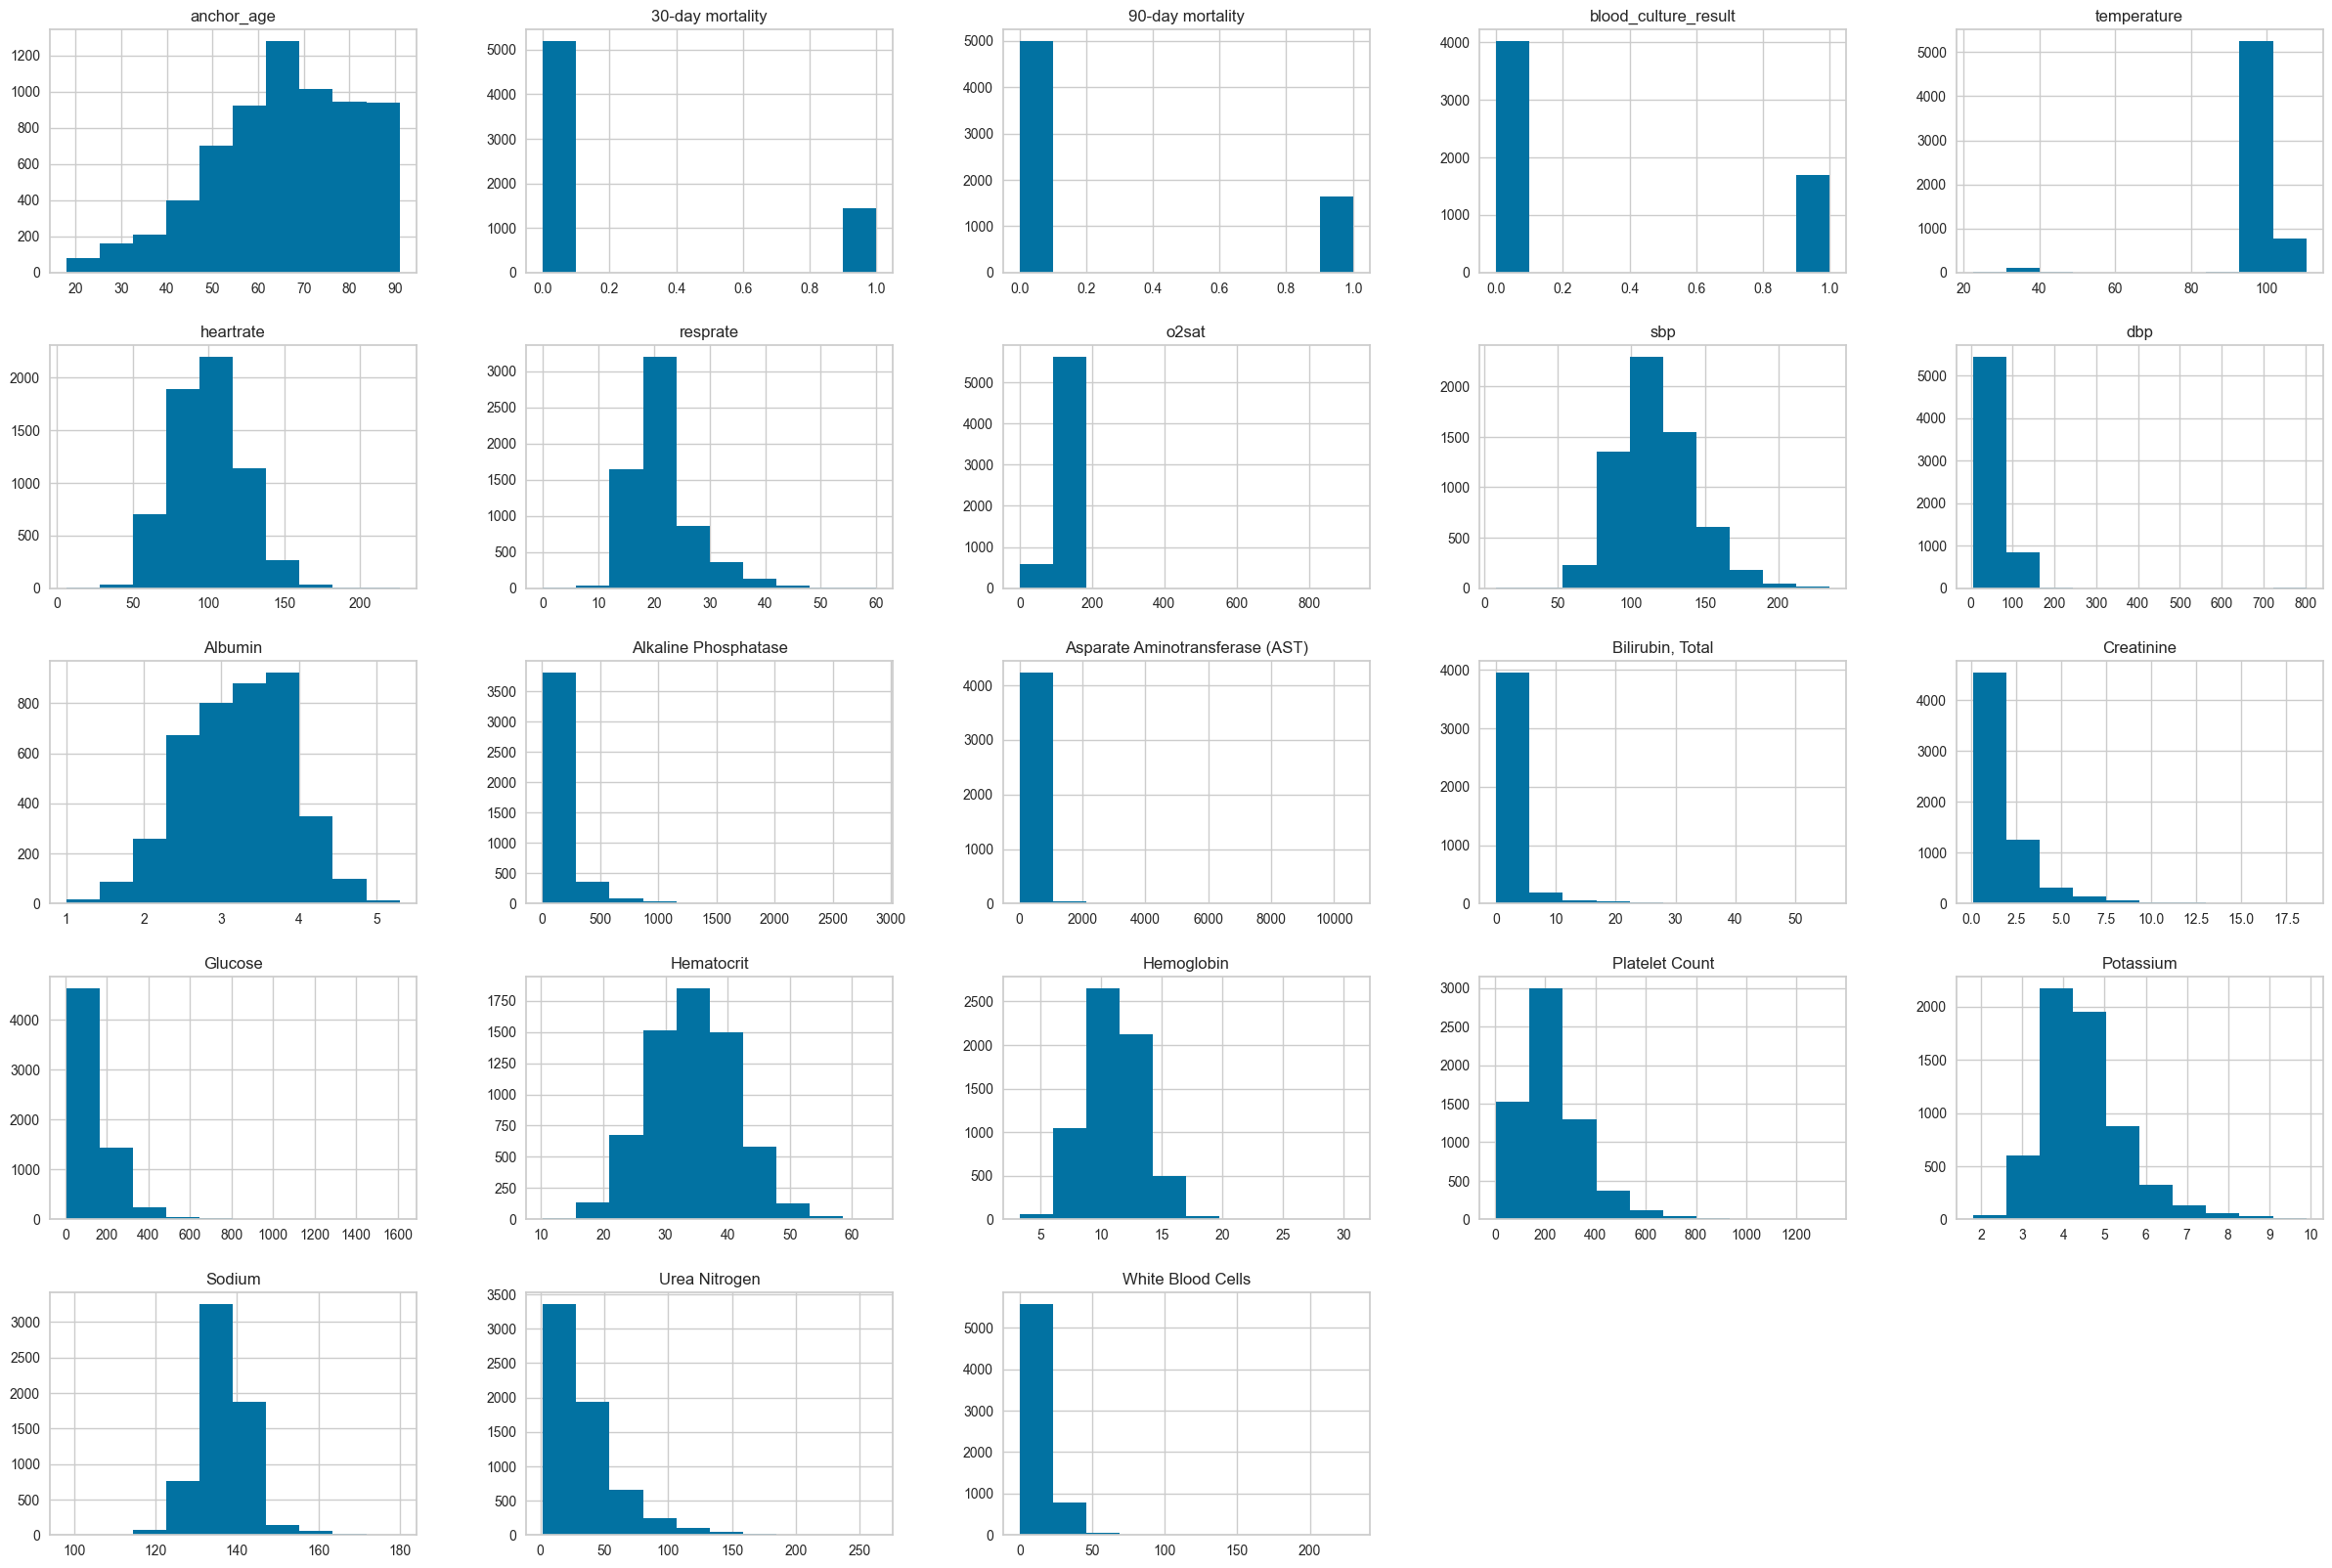

In [13]:
final.hist(figsize=(30, 20));

From the histograms above, there are several noteworthy aspects. Some of the vital sign features, such as temperature, saturation (o2sat), and diastolic blood pressure are skewed on the axis and seem to have some outliers. Let's have a closer look at their statistics.

In [14]:
final[["o2sat", "temperature", "dbp"]].describe()

,o2sat,temperature,dbp
count,6205.000000,6160.000000,6278.000000
mean,96.589202,97.879883,66.257248
std,11.487371,8.736975,22.263315
min,0.000000,22.400000,5.000000
25%,95.000000,97.800000,54.000000
50%,97.000000,98.500000,64.000000
75%,99.000000,100.000000,76.000000
max,921.000000,110.400000,802.000000


Some of the values in the overview above are physiologically impossible. Based on clinical definitions of physiological ranges, we clean the dataset and set impossible values to NaN. We further add some rules to check the correctness of the data. The laboratory tests also have some outlier values, but those all seem to be in the physiologically possible range. Let's clean the data and have another look at the histogram.

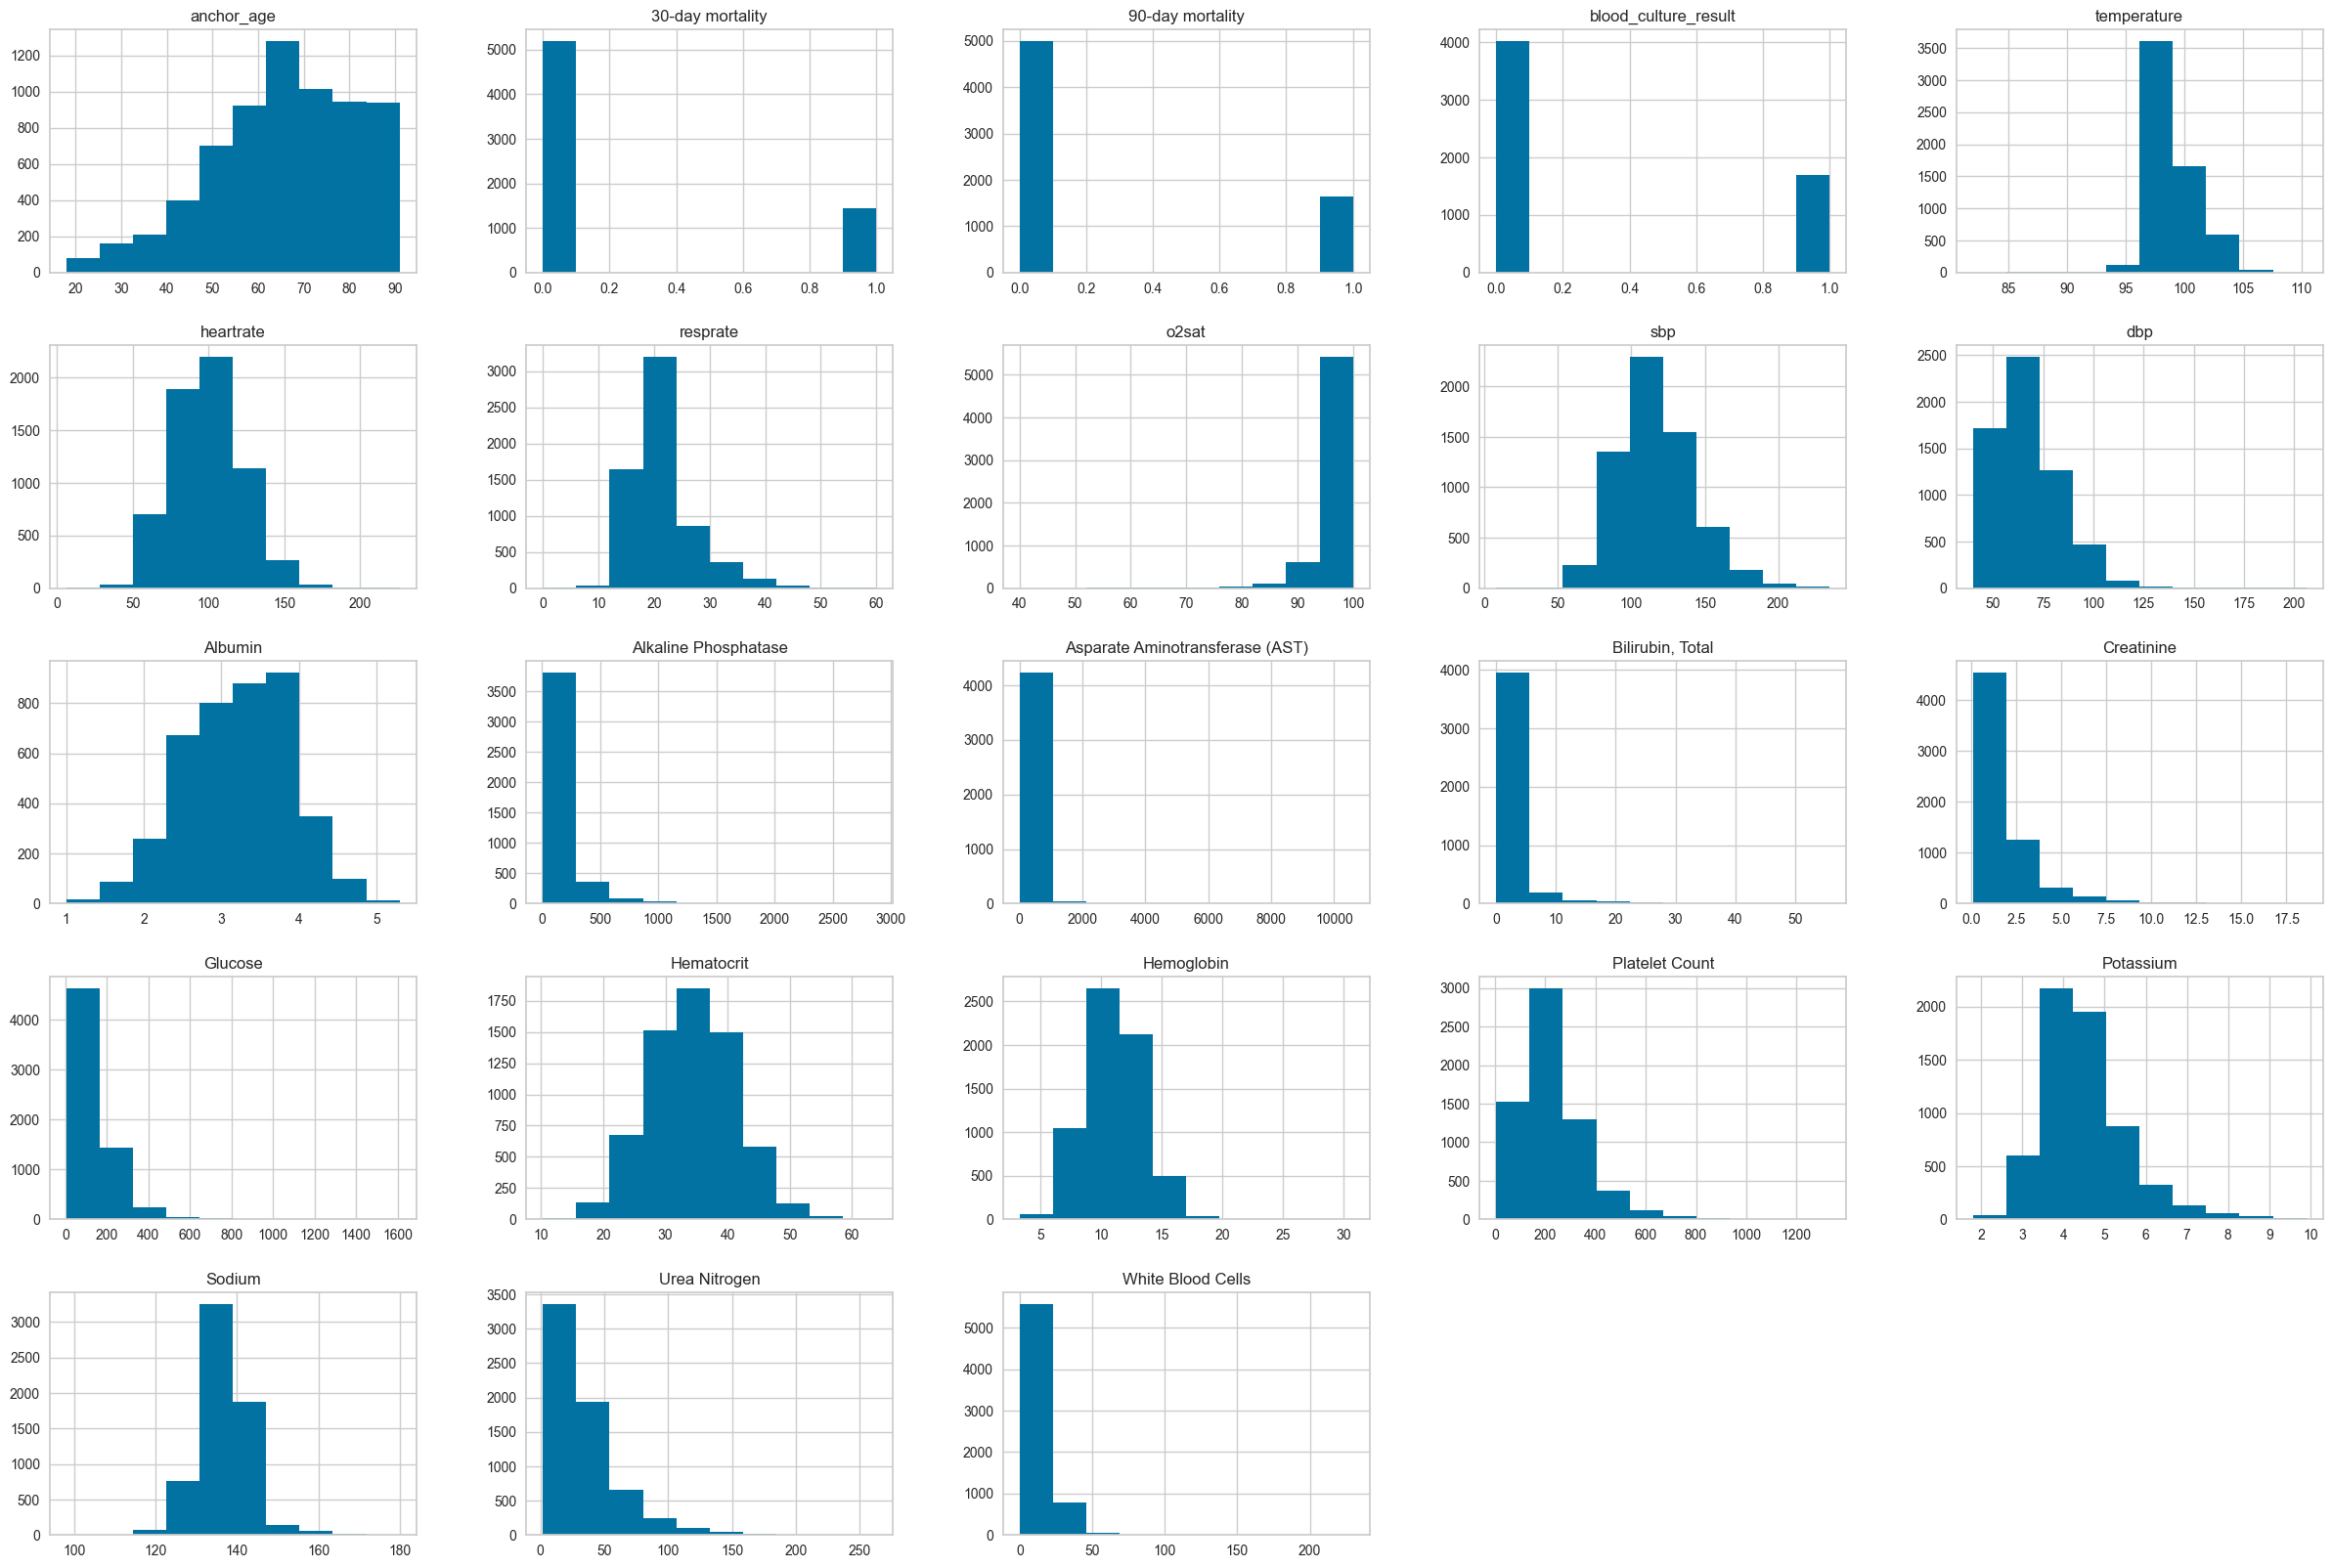

In [15]:
final["o2sat"] = np.where(final["o2sat"] > 100, np.NaN, final["o2sat"])
final["o2sat"] = np.where(final["o2sat"] < 40, np.NaN, final["o2sat"])

final["temperature"] = np.where(final["temperature"] < 82, np.NaN, final["temperature"])

final["dbp"] = np.where((final["dbp"] < 40) | (final["dbp"] > 250), np.NaN, final["dbp"])
final["dbp"] = np.where(final["sbp"] < final["dbp"], np.NaN, final["dbp"])
final["sbp"] = np.where(final["sbp"] < final["dbp"], np.NaN, final["sbp"])

final.hist(figsize=(30, 20));

The histograms above look a lot cleaner. We still have some distributions skewed to the left or right, but that's normal for blood-based measurements and capped variables like saturation (can't be more than 100%). We will use this dataset for our cluster analyses.

## Preprocessing and cluster analyses
Since there are a lot of records that have all variables measured, we will conduct the cluster analyses only on the records without missing values. We could also have chosen to impute the missing data in various ways. To conduct the analyses we will need to scale the features in order to do meaningful distance calculations. Since there are many nonnormally distributed variables, we will opt to use the MinMaxScaler, as opposed to the StandardScaler. Otherwise, we would loose a lot of the information contained in very high values. Besides the actions mentioned above, the cell below will also remove some of the outcome measures, such as mortality, from the dataframe for now. We will use those later to evaluate the clusters.

In [16]:
full = final.dropna()
full_outcomes = full[["30-day mortality", "90-day mortality", "blood_culture_result"]]
full_train = full.drop(["30-day mortality", "90-day mortality", "blood_culture_result"], axis=1)

scaler = MinMaxScaler()
scaled = scaler.fit_transform(full_train)

In [17]:
scaled.shape

(3160, 20)

Now that we have scaled data, we are ready to create clusters. In the set up below, we will start to evaluate a KMeans algorithm first. Initially, we will look at the Sum of the Squared Error (SSE) for various numbers of clusters in an elbow plot. 

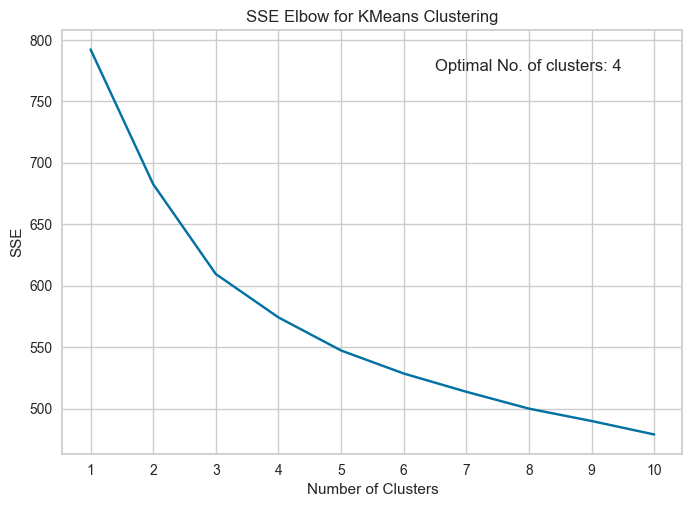

In [18]:
kmeans_args = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 0
}

sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_args)
    kmeans.fit(scaled)
    sse.append(kmeans.inertia_)

kl = KneeLocator(range(1,11), sse, curve="convex", direction="decreasing")

plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("SSE Elbow for KMeans Clustering")
plt.text(6.5, 775, ("Optimal No. of clusters: "+str(kl.elbow)))
plt.show()

The elbow plot above, based on the SSE, does not show a very clear "elbow" point. However, the KneeLocater function helps us find that the optimal number of clusters in this particular plot would be 4. Since the result is not that obvious, we will look at different methods to assess the optimal number of clusters as well. Below, we will look at the Silhouette Score.

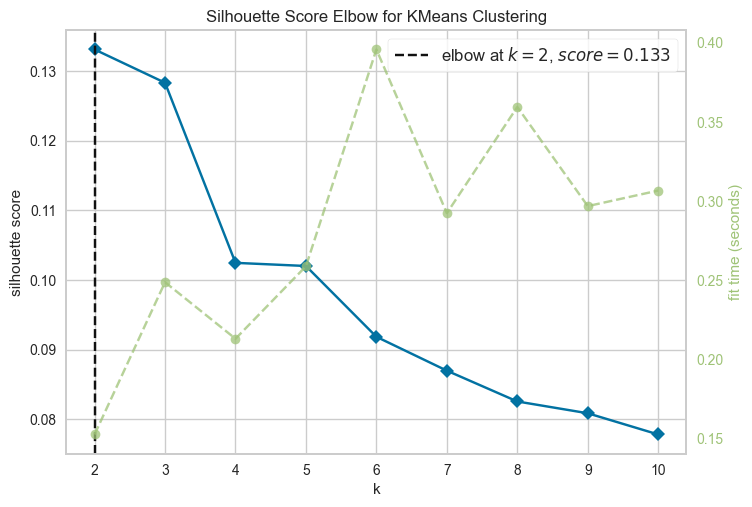

In [19]:
model = KMeans(n_clusters=k, **kmeans_args)
visualizer = KElbowVisualizer(model, k=(2,11), metric="silhouette")
visualizer.fit(scaled)
visualizer.show();

The Silhouette Score above suggests that we would need just 2 clusters. This result is different from the SSE methods. Furthermore, the silhouette score value of about 0.1 is fairly low. In the next cell, we will also investigate the Calinski Harabasz method to get further insights.

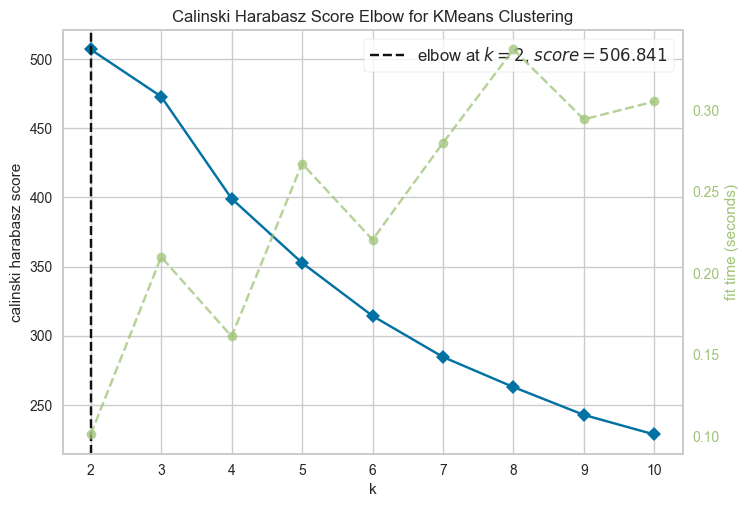

In [20]:
model = KMeans(n_clusters=k, **kmeans_args)
visualizer = KElbowVisualizer(model, k=(2,11), metric="calinski_harabasz")
visualizer.fit(scaled)
visualizer.show();

The Calinski Harabasz Score also suggests the elbow to be at 2 clusters. Still, the separation is not the most clear. Below, we will also look at a dendogram to inform clustering through agglomerative methods.

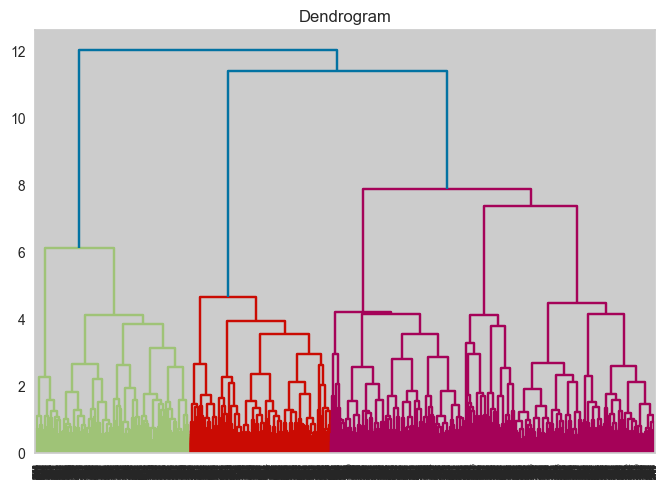

In [21]:
linkage_data = linkage(scaled, method='ward', metric='euclidean')
dendrogram(linkage_data)
plt.title("Dendrogram")
plt.show();


From the dendrogram it actually seems that it makes most sense to create three clusters. Through the various methods, we get conflicting results about how many clusters would be optimal. For the final outcome evaluation, we opt to present two clustering methods and their outcomes. For the hierarchical model, we will use three clusters. For the KMeans model, we will use two clusters (as that was the most frequent solution in the various methods above). Below, we train those models and assign their labels to the full dataset.

In [22]:
final_kmeans = KMeans(n_clusters=2, **kmeans_args)
final_kmeans.fit(scaled)
full["KMeans label"] = final_kmeans.labels_

final_hierarchical = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="ward")
final_hierarchical.fit(scaled)
full["Hierarchical label"] = final_hierarchical.labels_

Below, we will create two tables with the baseline characteristics and outcomes of the 3160 unique visits in the dataset, stratified by cluster assignment (either through KMeans label, or hierarchical label). The p-values are calculated by the TableOne function based on the type of data (numeric, categorical) and the normality of the data. Below, we first create the table for KMeans.

In [ ]:
columns = [
    "anchor_age",
    "30-day mortality",
    '90-day mortality',
    "blood_culture_result",
    "temperature",
    "heartrate",
    "resprate",
    "o2sat",
    "sbp",
    "dbp",
    "Albumin",
    "Alkaline Phosphatase",
    "Asparate Aminotransferase (AST)",
    "Bilirubin, Total",
    "Creatinine",
    "Glucose",
    "Hematocrit",
    "Hemoglobin",
    "Platelet Count",
    "Potassium",
    "Sodium",
    "Urea Nitrogen",
    "White Blood Cells"
]
categorical = ["30-day mortality", "90-day mortality", "blood_culture_result"]
groupby= ["KMeans label"]
nonnormal = [
    "o2sat",
    "sbp",
    "dbp",
    "Alkaline Phosphatase",
    "Asparate Aminotransferase (AST)",
    "Bilirubin, Total",
    "Creatinine",
    "Glucose",
    "White Blood Cells"
]
mytable = TableOne(full, columns=columns, categorical=categorical, groupby=groupby, pval=True)
mytable

Grouped by KMeans label                                                     
                                                               Missing        Overall              0              1 P-Value
n                                                                                3160           1663           1497        
anchor_age, mean (SD)                                                0    65.1 (15.8)     76.4 (9.0)    52.5 (11.6)  <0.001
30-day mortality, n (%)                    0                         0    2536 (80.3)    1339 (80.5)    1197 (80.0)   0.728
                                           1                               624 (19.7)     324 (19.5)     300 (20.0)        
90-day mortality, n (%)                    0                         0    2429 (76.9)    1297 (78.0)    1132 (75.6)   0.124
                                           1                               731 (23.1)     366 (22.0)     365 (24.4)        
blood_culture_result, n (%)                0.0                       0    2172 (68.7)    1142 (68.7)    1030 (68.8)   0.966
                                           1.0                             988 (31.3)     521 (31.3)     467 (31.2)        
temperature, mean (SD)                                               0     99.1 (2.0)     99.1 (2.1)     99.1 (1.9)   0.410
heartrate, mean (SD)                                                 0   100.5 (22.9)    98.0 (23.2)   103.3 (22.1)  <0.001
resprate, mean (SD)                                                  0     20.4 (5.6)     21.0 (6.1)     19.7 (4.8)  <0.001
o2sat, mean (SD)                                                     0     96.5 (3.8)     96.1 (4.2)     97.0 (3.3)  <0.001
sbp, mean (SD)                                                       0   115.6 (24.9)   119.5 (26.1)   111.2 (22.8)  <0.001
dbp, mean (SD)                                                       0    66.4 (16.0)    66.7 (16.2)    66.2 (15.8)   0.375
Albumin, mean (SD)                                                   0      3.2 (0.7)      3.4 (0.6)      3.1 (0.7)  <0.001
Alkaline Phosphatase, mean (SD)                                      0  173.6 (195.8)  152.4 (177.1)  197.2 (212.2)  <0.001
Asparate Aminotransferase (AST), mean (SD)                           0  126.9 (451.0)  115.1 (327.4)  140.1 (556.9)   0.130
Bilirubin, Total, mean (SD)                                          0      2.0 (4.1)      1.4 (2.2)      2.7 (5.5)  <0.001
Creatinine, mean (SD)                                                0      1.9 (1.7)      1.8 (1.4)      2.0 (1.9)   0.007
Glucose, mean (SD)                                                   0  156.8 (105.8)  162.8 (105.7)  150.1 (105.5)   0.001
Hematocrit, mean (SD)                                                0     34.1 (6.8)     36.0 (6.5)     31.9 (6.6)  <0.001
Hemoglobin, mean (SD)                                                0     11.0 (2.3)     11.6 (2.2)     10.3 (2.3)  <0.001
Platelet Count, mean (SD)                                            0  219.7 (134.7)  227.4 (128.5)  211.2 (140.8)   0.001
Potassium, mean (SD)                                                 0      4.5 (1.0)      4.6 (1.0)      4.4 (1.0)  <0.001
Sodium, mean (SD)                                                    0    136.4 (6.4)    138.0 (6.4)    134.6 (5.9)  <0.001
Urea Nitrogen, mean (SD)                                             0    34.9 (26.0)    37.6 (26.5)    31.9 (25.2)  <0.001
White Blood Cells, mean (SD)                                         0    14.6 (10.2)     15.2 (9.4)    14.0 (10.9)   0.001

As expected, we can see that most features differ significantly between the two KMeans clusters. Also, we can see that there is a large difference in mean age between the groups (76.4 vs 52.5). This is a very interesting finding since the mortality rates (19.5% vs 20%) are not significantly different, while this should certainly be the case for patients who are on average 25 years older. It means that we have found a cluster of young sepsis patients who are expected to do much worse than they should. These patients will likely have a very different immune response to sepsis than elderly patients, as the immunne response changes with age. Potentially, the patients in cluster 1, who are certainly in need of extensive treatment, may respond more similarly to certain therapies.

In the cell below, we take a closer look at what we would have found when using hierarchical clustering and three clusters.

In [ ]:
columns = [
    "anchor_age",
    "30-day mortality",
    '90-day mortality',
    "blood_culture_result",
    "temperature",
    "heartrate",
    "resprate",
    "o2sat",
    "sbp",
    "dbp",
    "Albumin",
    "Alkaline Phosphatase",
    "Asparate Aminotransferase (AST)",
    "Bilirubin, Total",
    "Creatinine",
    "Glucose",
    "Hematocrit",
    "Hemoglobin",
    "Platelet Count",
    "Potassium",
    "Sodium",
    "Urea Nitrogen",
    "White Blood Cells"
]
categorical = ["30-day mortality", "90-day mortality", "blood_culture_result"]
groupby= ["Hierarchical label"]
nonnormal = [
    "o2sat",
    "sbp",
    "dbp",
    "Alkaline Phosphatase",
    "Asparate Aminotransferase (AST)",
    "Bilirubin, Total",
    "Creatinine",
    "Glucose",
    "White Blood Cells"
]
mytable = TableOne(full, columns=columns, categorical=categorical, groupby=groupby, pval=True)
mytable

Grouped by Hierarchical label                                                                    
                                                                     Missing        Overall              0              1              2 P-Value
n                                                                                      3160           1652            791            717        
anchor_age, mean (SD)                                                      0    65.1 (15.8)    64.3 (13.2)    52.5 (14.1)     80.7 (7.6)  <0.001
30-day mortality, n (%)                    0                               0    2536 (80.3)    1237 (74.9)     746 (94.3)     553 (77.1)  <0.001
                                           1                                     624 (19.7)     415 (25.1)       45 (5.7)     164 (22.9)        
90-day mortality, n (%)                    0                               0    2429 (76.9)    1159 (70.2)     727 (91.9)     543 (75.7)  <0.001
                                           1                                     731 (23.1)     493 (29.8)       64 (8.1)     174 (24.3)        
blood_culture_result, n (%)                0.0                             0    2172 (68.7)    1148 (69.5)     530 (67.0)     494 (68.9)   0.460
                                           1.0                                   988 (31.3)     504 (30.5)     261 (33.0)     223 (31.1)        
temperature, mean (SD)                                                     0     99.1 (2.0)     98.8 (1.8)     99.7 (2.0)     99.1 (2.3)  <0.001
heartrate, mean (SD)                                                       0   100.5 (22.9)    97.2 (21.5)   108.6 (21.9)    99.3 (24.7)  <0.001
resprate, mean (SD)                                                        0     20.4 (5.6)     19.8 (4.9)     20.3 (5.5)     21.9 (6.6)  <0.001
o2sat, mean (SD)                                                           0     96.5 (3.8)     96.8 (3.5)     96.9 (2.8)     95.5 (5.1)  <0.001
sbp, mean (SD)                                                             0   115.6 (24.9)   109.8 (21.0)   119.2 (25.9)   125.0 (28.5)  <0.001
dbp, mean (SD)                                                             0    66.4 (16.0)    63.0 (13.9)    69.8 (16.1)    70.7 (18.5)  <0.001
Albumin, mean (SD)                                                         0      3.2 (0.7)      2.9 (0.6)      3.7 (0.5)      3.4 (0.6)  <0.001
Alkaline Phosphatase, mean (SD)                                            0  173.6 (195.8)  195.6 (227.8)  142.4 (140.7)  157.7 (158.4)  <0.001
Asparate Aminotransferase (AST), mean (SD)                                 0  126.9 (451.0)  142.3 (569.4)   98.8 (232.1)  122.4 (298.3)   0.080
Bilirubin, Total, mean (SD)                                                0      2.0 (4.1)      2.5 (5.3)      1.3 (1.8)      1.6 (2.4)  <0.001
Creatinine, mean (SD)                                                      0      1.9 (1.7)      2.2 (2.1)      1.4 (0.8)      1.6 (0.9)  <0.001
Glucose, mean (SD)                                                         0  156.8 (105.8)   148.3 (89.6)   156.4 (91.4)  176.7 (145.1)  <0.001
Hematocrit, mean (SD)                                                      0     34.1 (6.8)     30.1 (5.6)     38.4 (5.6)     38.3 (5.2)  <0.001
Hemoglobin, mean (SD)                                                      0     11.0 (2.3)      9.6 (1.8)     12.6 (1.9)     12.3 (1.7)  <0.001
Platelet Count, mean (SD)                                                  0  219.7 (134.7)  222.0 (157.0)  217.3 (104.4)  217.1 (105.6)   0.605
Potassium, mean (SD)                                                       0      4.5 (1.0)      4.5 (1.1)      4.3 (0.9)      4.6 (0.9)  <0.001
Sodium, mean (SD)                                                          0    136.4 (6.4)    135.7 (6.6)    136.2 (5.4)    138.3 (6.6)  <0.001
Urea Nitrogen, mean (SD)                                                   0    34.9 (26.0)    40.1 (30.3)    23.3 (14.2)    35.6 (2

The hierarchical cluster analysis shows very different results to the KMeans approach. The cluster 1 againn has very young patients (52.5 years average), but these now have a much lower mortality rate (5.7%). This is to be expected since they are so much younger than the other cohorts. We also see that these patients in cluster 1 have a higher white blood cell count, heartrate, and temperature. These indicate a more inflammatory type of sepsis, which may respond best to anti-inflammatory medications. Most interesting among these results is cluster 0. The patients are slightly older than in cluster 1 of the KMeans approach, but it shows similarly high mortality rates which should not have exceeded those in cluster 2, of patients 15 years older. This cluster 1 has the most abberant liver and kidney function tests, indicating chronic illnesses. Finally, cluster 2 has pretty high mortality rates (22.9%), but these patients are very old. It makes sense that the mortality rates are higher. Nevertheless, these patients seem to have relatively normal laboratory tests and excellent vital signs given the circumstances. We are looking at relatively fit and healthy elderly.

## Conclusion
To conclude, we were able use the MIMIC-IV data to cluster sepsis patients into more homogeneous subgroups. Various methods to decide on the optimal number of clusters came up with different results. Both methods we investigated (Kmeans with two clusters, hierarchical with three clusters) provided interesting insights. We can't yet conclude the best way of doing it. Further analyses are needed to see of any of these findings are robust and replicable in other settings.
